In [2]:
import torch
import math
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from os import path

In [36]:
# config
D_MODEL = 512 # Dimension of input token representation - embeddings
VOCAB_SIZE = 50000 # Number of tokens in vocabulary
MAX_SEQ_LEN = 64 # Maximum Sequence Length of Input and Output Sequence
NUM_LAYERS = 2 # Number of encoder and decoder stacks
ATTN_DROPOUT = 0.2 # Quantify the dropout of how much in attention
EPS = 1e-6 # A small value to avoid zero division error while normalization
FF_DROPOUT = 0.2 # How much dropout in FFN``
NUM_HEADS = 8 # Number of attention heads
RES_DROPOUT = 0.2 # Dropout for residual connection
WEIGHT_DECAY = 0.01
GRAD_CLIP = 2.0
TOKENIZER_PATH = "tokenizer.json" # Tokenizer path
DATASET_ID = "emotion_data.parquet" # Dataset path
SRC_CLN_NAME = "text" # Source column name
TGT_CLN_NAME = "label" # Target column name
LOG_DIR = "logs/v1" # Logging dir
BATCH_SIZE = 10 # Number of samples per batch
LR = 1e-4 # Learning Rate for optimizer
NUM_EPOCHS = 100# Number of training epochs
MODEL_SAVE_PATH = "transformer_classifier" # Model save path
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# dataloader

In [4]:
# Token embedding

class TokenEmbeddings(nn.Module):
    
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(
                                        num_embeddings=vocab_size,
                                        embedding_dim=d_model
                                    )
        
    def forward(self, x: torch.Tensor):
        token_embedding = self.embedding(x)
        return token_embedding
a  = torch.ones((BATCH_SIZE, MAX_SEQ_LEN-2), dtype = torch.int64)
TE = TokenEmbeddings(D_MODEL, VOCAB_SIZE)
print(TE(a).shape)

torch.Size([10, 30, 512])


In [5]:
# positional embedding

class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model: int, seq_len: int, dropout_p: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout_p)
        position_encodings = torch.zeros(self.seq_len, self.d_model)
        positions = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
        even_odd_i = torch.arange(0, self.d_model, 2).float()
        div_freqs_term = torch.pow(10000, even_odd_i/d_model)
        position_encodings[:, 0::2] = torch.sin(positions*div_freqs_term)
        position_encodings[:, 1::2] = torch.cos(positions*div_freqs_term)
        position_encodings = position_encodings.unsqueeze(0)
        self.register_buffer('position_encodings', position_encodings)
        
    def forward(self, x: torch.Tensor):
        x = x + (self.position_encodings[:, :x.shape[1], :]).requires_grad_(False)
        pos_encoding = self.dropout(x)
        return pos_encoding
a  = torch.ones((BATCH_SIZE, MAX_SEQ_LEN-2, D_MODEL))
PE = PositionalEncoding(D_MODEL, MAX_SEQ_LEN, FF_DROPOUT)
print(PE(a).shape)

torch.Size([10, 30, 512])


In [6]:
# input embeddings

class InputEmbeddings(nn.Module):

    def __init__(self):
        super().__init__()
        self.d_model = D_MODEL
        self.vocab_size = VOCAB_SIZE
        self.seq_len = MAX_SEQ_LEN
        self.dropout_p = FF_DROPOUT
        self.token_embedding = TokenEmbeddings(self.d_model, self.vocab_size)
        self.positional_encoding = PositionalEncoding(self.d_model, self.seq_len, self.dropout_p)

    def forward(self, x: torch.Tensor):
        token_embed_x = self.token_embedding(x)
        inp_embedding = self.positional_encoding(token_embed_x)
        return inp_embedding

a  = torch.ones((BATCH_SIZE, MAX_SEQ_LEN-2), dtype = torch.int64)
IE = InputEmbeddings()
print(IE(a).shape)

torch.Size([10, 30, 512])


In [7]:
# load training dataset for tokenizer

from datasets import load_dataset

data_id = "stanfordnlp/imdb"
tokenizer_dataset = load_dataset(data_id, split="train")
print(tokenizer_dataset['text'][0][:20], tokenizer_dataset['label'][0])
print(set(tokenizer_dataset['label']))

I rented I AM CURIOU 0
{0, 1}


In [8]:
# make iterator for the dataset

from tokenizers import Tokenizer

def tokenizer_dataset_iterator(dataset):
    for data in dataset:
        yield data["text"]
for a in tokenizer_dataset_iterator(tokenizer_dataset):
    print(a[:20])
    break

I rented I AM CURIOU


In [9]:
# Initialize tokenizer

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
if path.exists("tokenizer.json"):
    tokenizer = Tokenizer.from_file("tokenizer.json")
else:
    tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer_trainer = WordLevelTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[PAD]", "[SOS]", "[EOS]", "[UNK]"], min_frequency=2)
    tokenizer.train_from_iterator(tokenizer_dataset_iterator(tokenizer_dataset), trainer=tokenizer_trainer)
    tokenizer.save("tokenizer.json")
print(tokenizer.encode("[PAD] [SOS] [EOS] [UNK]").ids)
print(tokenizer.encode(a[:30]).ids)
print(tokenizer.encode("7569").ids)

[0, 1, 2, 3]
[15, 1718, 15, 14456, 34507, 20, 26873, 3228]
[3]


In [10]:
# classification dataset

from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, dataset_id: str, tokenizer: Tokenizer, max_seq_len: int,  src_cln_name: str, tgt_cln_name: str, split: str):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        self.src_cln_name = src_cln_name
        self.tgt_cln_name = tgt_cln_name
        self.dataset_id = dataset_id
        #self.dataset = HFDataset.from_pandas(pd.read_parquet(DATASET_ID).sample(frac=1))
        self.dataset = load_dataset(self.dataset_id, split=split)
        self.sos_token = torch.tensor([tokenizer.token_to_id("[SOS]")]).to(torch.int64)
        self.eos_token = torch.tensor([tokenizer.token_to_id("[EOS]")]).to(torch.int64)
        self.pad_token = torch.tensor([tokenizer.token_to_id("[PAD]")]).to(torch.int64)

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):

        data = self.dataset[index]
        src_data = data[self.src_cln_name]
        tgt_data = data[self.tgt_cln_name]
        encoder_inp_tokens = torch.tensor(self.tokenizer.encode(src_data).ids).to(torch.int64)
        decoder_inp_tokens = torch.tensor(self.tokenizer.encode(str(tgt_data)).ids).to(torch.int64)

        if encoder_inp_tokens.size(0) > self.max_seq_len-2:
            encoder_inp_tokens = encoder_inp_tokens[:self.max_seq_len-2]

        encoder_num_padding_tokens = self.max_seq_len - len(encoder_inp_tokens) - 2
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_inp_tokens) - 1

        encoder_inp_pad_tokens = torch.tensor([self.pad_token] * encoder_num_padding_tokens).to(torch.int64)
        decoder_inp_pad_tokens = torch.tensor([self.pad_token] * decoder_num_padding_tokens).to(torch.int64) 
        label_pad_tokens = torch.tensor([self.pad_token] * decoder_num_padding_tokens).to(torch.int64)

        encoder_inp_tokens = torch.cat([self.sos_token, encoder_inp_tokens, self.eos_token, encoder_inp_pad_tokens], dim=0)
        decoder_inpp_tokens = torch.cat([self.sos_token, decoder_inp_tokens, decoder_inp_pad_tokens], dim=0)
        label_tokens = torch.cat([decoder_inp_tokens, self.eos_token, label_pad_tokens], dim=0)
        
        encoder_attn_mask = (encoder_inp_tokens != self.pad_token).unsqueeze(0).unsqueeze(0).to(torch.int64)
        auto_regressive_mask = torch.tril(torch.ones((1, decoder_inpp_tokens.size(0), decoder_inpp_tokens.size(0))), diagonal=0).type(torch.int64)
        decoder_attn_mask = ((decoder_inpp_tokens != self.pad_token).unsqueeze(0).to(torch.int64) & auto_regressive_mask).to(torch.int64)
        
        model_inp = {}
        model_inp["encoder_input_ids"] = encoder_inp_tokens
        model_inp["decoder_input_ids"] = decoder_inpp_tokens
        model_inp["encoder_attention_mask"] = encoder_attn_mask
        model_inp["decoder_attention_mask"] = decoder_attn_mask
        model_inp["labels"] = label_tokens
        model_inp["source"] = src_data
        model_inp["target"] = tgt_data
        return model_inp

CD_train = ClassificationDataset(data_id, tokenizer, MAX_SEQ_LEN, "text", "label", "train")
CD_test = ClassificationDataset(data_id, tokenizer, MAX_SEQ_LEN, "text", "label", "test")

In [11]:
CD_train[0]["decoder_attention_mask"]

tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0]]])

# Models

In [12]:
# Fully connected

class FeedForward(nn.Module):

    def __init__(self, d_model: int, ff_dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.ff_dropout = ff_dropout
        self.d_ff = self.d_model * 4
        self.linear_1 = nn.Linear(self.d_model, self.d_ff)
        self.linear_2 = nn.Linear(self.d_ff, self.d_model)
        self.ff_dropout_layer = nn.Dropout(self.ff_dropout)
        self.activation_fn = torch.relu

    def forward(self, x:torch.Tensor):
        linear_1_out = self.linear_1(x)
        linear_1_out = self.activation_fn(linear_1_out)
        linear_1_out = self.ff_dropout_layer(linear_1_out)
        ff_out = self.linear_2(linear_1_out)
        return ff_out
        
FF = FeedForward(D_MODEL, FF_DROPOUT)
a  = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
print(FF(a).shape)

torch.Size([10, 32, 512])


In [13]:
# Multi-head attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, num_heads: int, attn_dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(attn_dropout)

    def attention_calculation(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor):
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1)
        if self.dropout is not None:
            attention_scores = self.dropout(attention_scores)
        return (attention_scores @ value), attention_scores

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, attn_mask: torch.Tensor):
        query = self.wq(q)
        key = self.wk(k)
        value = self.wv(v)
        query = query.view(query.shape[0], query.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads, self.head_dim).transpose(1, 2)
        x, self.attention_scores = self.attention_calculation(query, key, value, attn_mask)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.d_model)  
        attn_out = self.wo(x)
        return attn_out
        
q = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
k = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
v = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
MHA = MultiHeadAttention(D_MODEL, NUM_HEADS, ATTN_DROPOUT)
print(MHA(q, k, v, None).shape)

torch.Size([10, 32, 512])


In [14]:
# Residual connection and layernorm

class LayerNorm(nn.Module):

    def __init__(self, d_model: int, eps: float) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

    def forward(self, x:torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        x_normalized = (x - mean)/(std + self.eps) 
        layer_norm_out = self.alpha * x_normalized + self.beta
        return layer_norm_out

class ResidualConnection(nn.Module):

    def __init__(self, d_model: int, res_dropout: float):
        super().__init__()
        self.dropout_layer = nn.Dropout(res_dropout)
        self.layer_norm_layer = LayerNorm(d_model, 1e-6)

    def forward(self, x, sublayer):
        sublayer_out = self.dropout_layer(sublayer(self.layer_norm_layer(x)))
        add_layer_norm_out = x + sublayer_out
        return add_layer_norm_out
        
a = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
RES = ResidualConnection(D_MODEL, RES_DROPOUT)
print(RES(a, FF).shape)

torch.Size([10, 32, 512])


In [15]:
# encoder

class EncoderBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.d_model = D_MODEL
        self.num_heads = NUM_HEADS
        self.attn_dropout = ATTN_DROPOUT
        self.ff_dropout = FF_DROPOUT
        self.res_dropout = RES_DROPOUT
        self.self_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout)
        self.feed_forward = FeedForward(self.d_model, self.ff_dropout)
        self.res_connection1 = ResidualConnection(self.d_model, self.res_dropout)
        self.res_connection2 = ResidualConnection(self.d_model, self.res_dropout)

    def forward(self, x: torch.Tensor, src_attn_mask: torch.Tensor):
        attn_out = self.res_connection1(x, lambda x: self.self_attention(x, x, x, src_attn_mask))
        enc_block_out = self.res_connection2(attn_out, self.feed_forward)
        return enc_block_out
    
class Encoder(nn.Module):

    def __init__(self, d_model: int, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock() for _ in range(num_layers)])
        self.layer_norm = LayerNorm(d_model, EPS)

    def forward(self, x:torch.Tensor, attn_mask: torch.Tensor):
        for layer in self.layers:
            x = layer(x, attn_mask)
        encoder_out = self.layer_norm(x)
        return encoder_out

a = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
ENC = Encoder(D_MODEL, NUM_LAYERS)
print(ENC(a, None).shape)

torch.Size([10, 32, 512])


In [16]:
# Decoder

class DecoderBlock(nn.Module):

    def __init__(self):
        super().__init__()
        self.d_model = D_MODEL
        self.num_heads = NUM_HEADS
        self.attn_dropout = ATTN_DROPOUT
        self.ff_dropout = FF_DROPOUT
        self.res_dropout = RES_DROPOUT
        self.self_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout)
        self.cross_attention = MultiHeadAttention(self.d_model, self.num_heads, self.attn_dropout)
        self.feed_forward = FeedForward(self.d_model, self.ff_dropout)
        self.res_connection1 = ResidualConnection(self.d_model, self.res_dropout)
        self.res_connection2 = ResidualConnection(self.d_model, self.res_dropout)
        self.res_connection3 = ResidualConnection(self.d_model, self.res_dropout)

    def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, src_attn_mask: torch.Tensor, tgt_attn_mask: torch.Tensor):
        self_attn_out = self.res_connection1(x, lambda x: self.self_attention(x, x, x, tgt_attn_mask))
        cross_attn_out = self.res_connection2(self_attn_out, lambda self_attn_out: self.cross_attention(self_attn_out, encoder_out, encoder_out, src_attn_mask))
        dec_block_out = self.res_connection3(cross_attn_out, self.feed_forward)
        return dec_block_out
    
class Decoder(nn.Module):

    def __init__(self, d_model: int, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock() for _ in range(num_layers)])
        self.layer_norm = LayerNorm(d_model, EPS)

    def forward(self, x:torch.Tensor, encoder_out: torch.Tensor, src_attn_mask: torch.Tensor, tgt_attn_mask: torch.Tensor):
        for layer in self.layers:
            x = layer(x, encoder_out, src_attn_mask, tgt_attn_mask)
        decoder_out = self.layer_norm(x)
        return decoder_out

a = torch.rand((BATCH_SIZE, MAX_SEQ_LEN, D_MODEL))
DEC = Decoder(D_MODEL, NUM_LAYERS)
print(DEC(a, a, None, None).shape)

torch.Size([10, 32, 512])


In [17]:
# transformer

class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.d_model = D_MODEL
        self.num_layers = NUM_LAYERS
        self.vocab_size = VOCAB_SIZE
        self.inp_embedding = InputEmbeddings()
        self.encoder = Encoder(self.d_model, self.num_layers)
        self.decoder = Decoder(self.d_model, self.num_layers)
        self.projection = nn.Linear(self.d_model, self.vocab_size)
        self.__init__weights()

    def forward(self, src_x, src_attn_mask, tgt_x, tgt_attn_mask):
        src_embed = self.inp_embedding(src_x)
        tgt_embed = self.inp_embedding(tgt_x)
        encoder_out = self.encoder(src_embed, src_attn_mask)
        decoder_out = self.decoder(tgt_embed, encoder_out, src_attn_mask, tgt_attn_mask)
        transformer_out = self.projection(decoder_out)
        return transformer_out
    
    def __init__weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
T = Transformer()
a = torch.ones((BATCH_SIZE, MAX_SEQ_LEN), dtype = torch.int64)
b = torch.ones((BATCH_SIZE, MAX_SEQ_LEN), dtype = torch.int64)
print(T(a,None,b,None).shape)

torch.Size([10, 32, 50000])


In [18]:
# loss computation

def compute_loss(logits: torch.Tensor, labels: torch.Tensor, loss_fn):
    logits = logits.view(-1, VOCAB_SIZE)
    labels = labels.view(-1)
    loss = loss_fn(logits, labels)
    return loss

In [37]:
# train

print("Loading the datasets...")
#CD_train = ClassificationDataset(data_id, tokenizer, MAX_SEQ_LEN, "text", "label", "train")
#CD_test = ClassificationDataset(data_id, tokenizer, MAX_SEQ_LEN, "text", "label", "test")

train_dl = DataLoader(CD_train, BATCH_SIZE, num_workers=0, pin_memory=True, shuffle=True)
test_dl = DataLoader(CD_test, BATCH_SIZE, num_workers=0, pin_memory=True)

print("Initialize model...")
model = Transformer()
model.to(DEVICE)

opt = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, LR, epochs=NUM_EPOCHS, steps_per_epoch=len(train_dl))
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id('[PAD]')).to("cuda")

train_ = []
test_ = []

for e in range(NUM_EPOCHS):
    model.train()
    train_losses = []
    test_losses = []
    for batch in tqdm(train_dl, desc=f"Training {e}"):
        
        src_x = batch["encoder_input_ids"].to(DEVICE)
        src_attn_mask = batch["encoder_attention_mask"].to(DEVICE)
        tgt_x = batch["decoder_input_ids"].to(DEVICE)
        tgt_attn_mask = batch["decoder_attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        
        model_logits = model(src_x, src_attn_mask, tgt_x, tgt_attn_mask)
        
        loss = compute_loss(model_logits, labels, loss_fn )
        
        loss.backward()

        nn.utils.clip_grad_value_(model.parameters(), GRAD_CLIP)
        
        opt.step()
        
        opt.zero_grad(set_to_none=True)
        sched.step()
    with torch.no_grad():
        model.eval()
        for batch in tqdm(train_dl, desc=f"Training loss {e}"):
            src_x = batch["encoder_input_ids"].to(DEVICE)
            src_attn_mask = batch["encoder_attention_mask"].to(DEVICE)
            tgt_x = batch["decoder_input_ids"].to(DEVICE)
            tgt_attn_mask = batch["decoder_attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            
            model_logits = model(src_x, src_attn_mask, tgt_x, tgt_attn_mask)
            
            loss = compute_loss(model_logits, labels, loss_fn )
    
            train_losses.append(loss.item())
        print(sum(train_losses)/len(train_losses))
        train_.append(sum(train_losses)/len(train_losses))
        for batch in tqdm(test_dl, desc=f"Testing loss {e}"):
            src_x = batch["encoder_input_ids"].to(DEVICE)
            src_attn_mask = batch["encoder_attention_mask"].to(DEVICE)
            tgt_x = batch["decoder_input_ids"].to(DEVICE)
            tgt_attn_mask = batch["decoder_attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            
            model_logits = model(src_x, src_attn_mask, tgt_x, tgt_attn_mask)
            
            loss = compute_loss(model_logits, labels, loss_fn )

            test_losses.append(loss.item())
        print(sum(test_losses)/len(test_losses))
        test_.append(sum(test_losses)/len(test_losses))
    # save checkpoints
    ckpt_path = "checkpoints/"+f"epoch-{e}-checkpoint.pth"
    torch.save({
        "model": model.state_dict(),
        "optimizer": opt.state_dict(),
        "scheduler": sched.state_dict(),
    }, ckpt_path)


Loading the datasets...
Initialize model...


Training loss 0: 100%|██████████| 2500/2500 [00:44<00:00, 55.79it/s]


2.9935561979293825


Testing loss 0: 100%|██████████| 2500/2500 [00:44<00:00, 56.38it/s]


2.9935563274383545


Training loss 1: 100%|██████████| 2500/2500 [00:45<00:00, 54.52it/s]


0.5594883009195327


Testing loss 1: 100%|██████████| 2500/2500 [00:44<00:00, 55.87it/s]


0.5594879052639008


Training loss 2: 100%|██████████| 2500/2500 [00:46<00:00, 53.23it/s]


0.3798830001115799


Testing loss 2: 100%|██████████| 2500/2500 [00:45<00:00, 55.45it/s]


0.379882633960247


Training loss 3: 100%|██████████| 2500/2500 [00:46<00:00, 53.50it/s]


0.3567025749921799


Testing loss 3: 100%|██████████| 2500/2500 [00:45<00:00, 54.90it/s]


0.3567024514079094


Training loss 4: 100%|██████████| 2500/2500 [00:47<00:00, 52.70it/s]


0.35143837517499926


Testing loss 4: 100%|██████████| 2500/2500 [00:45<00:00, 54.63it/s]


0.3514383689522743


Training loss 5: 100%|██████████| 2500/2500 [00:47<00:00, 52.90it/s]


0.349987625169754


Testing loss 5: 100%|██████████| 2500/2500 [00:45<00:00, 54.79it/s]


0.3499876247882843


Training loss 6: 100%|██████████| 2500/2500 [00:47<00:00, 52.85it/s]


0.3548777103424072


Testing loss 6: 100%|██████████| 2500/2500 [00:45<00:00, 55.40it/s]


0.3548777103424072


Training loss 7: 100%|██████████| 2500/2500 [00:47<00:00, 53.13it/s]


0.3495593305110931


Testing loss 7: 100%|██████████| 2500/2500 [00:45<00:00, 55.19it/s]


0.34955933690071106


Training loss 8: 100%|██████████| 2500/2500 [00:47<00:00, 52.80it/s]


0.34917253255844116


Testing loss 8: 100%|██████████| 2500/2500 [00:45<00:00, 55.49it/s]


0.34917253255844116


Training loss 9: 100%|██████████| 2500/2500 [00:47<00:00, 52.75it/s]


0.3502719679951668


Testing loss 9: 100%|██████████| 2500/2500 [00:45<00:00, 55.24it/s]


0.3502719849348068


Training loss 10: 100%|██████████| 2500/2500 [00:41<00:00, 59.62it/s]


0.3496589412331581


Testing loss 10: 100%|██████████| 2500/2500 [00:40<00:00, 61.56it/s]


0.34965893626213074


Training loss 11: 100%|██████████| 2500/2500 [00:42<00:00, 59.37it/s]


0.351377580678463


Testing loss 11: 100%|██████████| 2500/2500 [00:41<00:00, 59.98it/s]


0.35137757643461226


Training loss 12: 100%|██████████| 2500/2500 [00:41<00:00, 59.76it/s]


0.3517321347475052


Testing loss 12: 100%|██████████| 2500/2500 [00:40<00:00, 61.47it/s]


0.35173211991786957


Training loss 13: 100%|██████████| 2500/2500 [00:42<00:00, 59.25it/s]


0.35230426869392395


Testing loss 13: 100%|██████████| 2500/2500 [00:42<00:00, 59.43it/s]


0.35230427980422974


Training loss 14: 100%|██████████| 2500/2500 [00:45<00:00, 54.51it/s]


0.35346810907125475


Testing loss 14: 100%|██████████| 2500/2500 [00:44<00:00, 56.52it/s]


0.353468120098114


Training loss 15: 100%|██████████| 2500/2500 [00:45<00:00, 54.42it/s]


0.3534524193048477


Testing loss 15: 100%|██████████| 2500/2500 [00:44<00:00, 55.97it/s]


0.3534524142742157


Training loss 16: 100%|██████████| 2500/2500 [00:46<00:00, 53.42it/s]


0.35348254425525666


Testing loss 16: 100%|██████████| 2500/2500 [00:44<00:00, 56.22it/s]


0.35348252952098846


Training loss 17: 100%|██████████| 2500/2500 [00:41<00:00, 59.93it/s]


0.35254865882396696


Testing loss 17: 100%|██████████| 2500/2500 [00:40<00:00, 62.15it/s]


0.35254864394664764


Training loss 18: 100%|██████████| 2500/2500 [00:40<00:00, 61.21it/s]


0.35166993987560274


Testing loss 18: 100%|██████████| 2500/2500 [00:39<00:00, 63.02it/s]


0.35166993737220764


Training loss 19: 100%|██████████| 2500/2500 [00:46<00:00, 53.27it/s]


0.3516523240566254


Testing loss 19: 100%|██████████| 2500/2500 [00:44<00:00, 56.32it/s]


0.3516523241996765


Training loss 20: 100%|██████████| 2500/2500 [00:47<00:00, 53.18it/s]


0.35096586458683016


Testing loss 20: 100%|██████████| 2500/2500 [00:44<00:00, 56.03it/s]


0.35096585750579834


Training loss 21: 100%|██████████| 2500/2500 [00:46<00:00, 53.91it/s]


0.3529063175797462


Testing loss 21: 100%|██████████| 2500/2500 [00:44<00:00, 56.10it/s]


0.35290631651878357


Training loss 22: 100%|██████████| 2500/2500 [00:46<00:00, 54.09it/s]


0.3512192886829376


Testing loss 22: 100%|██████████| 2500/2500 [00:40<00:00, 61.63it/s]


0.3512192964553833


Training loss 23: 100%|██████████| 2500/2500 [00:41<00:00, 59.69it/s]


0.35145214676856995


Testing loss 23: 100%|██████████| 2500/2500 [00:40<00:00, 61.59it/s]


0.35145212709903717


Training loss 24: 100%|██████████| 2500/2500 [00:41<00:00, 59.81it/s]


0.3505292749285698


Testing loss 24: 100%|██████████| 2500/2500 [00:40<00:00, 62.05it/s]


0.3505292683839798


Training loss 25: 100%|██████████| 2500/2500 [00:41<00:00, 60.14it/s]


0.35024201134443284


Testing loss 25: 100%|██████████| 2500/2500 [00:40<00:00, 62.04it/s]


0.350242018699646


Training loss 26: 100%|██████████| 2500/2500 [00:41<00:00, 59.90it/s]


0.35066472754478456


Testing loss 26: 100%|██████████| 2500/2500 [00:40<00:00, 61.96it/s]


0.35066473484039307


Training loss 27: 100%|██████████| 2500/2500 [00:42<00:00, 59.40it/s]


0.3502116281867027


Testing loss 27: 100%|██████████| 2500/2500 [00:40<00:00, 61.36it/s]


0.35021162033081055


Training loss 28: 100%|██████████| 2500/2500 [00:41<00:00, 60.37it/s]


0.3498586869597435


Testing loss 28: 100%|██████████| 2500/2500 [00:40<00:00, 61.82it/s]


0.34985868632793427


Training loss 29: 100%|██████████| 2500/2500 [00:41<00:00, 59.82it/s]


0.34986711267232895


Testing loss 29: 100%|██████████| 2500/2500 [00:43<00:00, 57.55it/s]


0.3498671054840088


Training loss 30: 100%|██████████| 2500/2500 [00:47<00:00, 53.11it/s]


0.349857210958004


Testing loss 30: 100%|██████████| 2500/2500 [00:44<00:00, 55.62it/s]


0.3498572111129761


Training loss 31: 100%|██████████| 2500/2500 [00:46<00:00, 53.46it/s]


0.3495367481231689


Testing loss 31: 100%|██████████| 2500/2500 [00:44<00:00, 55.64it/s]


0.3495367467403412


Training loss 32: 100%|██████████| 2500/2500 [00:41<00:00, 59.69it/s]


0.3491070977807045


Testing loss 32: 100%|██████████| 2500/2500 [00:40<00:00, 61.13it/s]


0.3491070866584778


Training loss 33: 100%|██████████| 2500/2500 [00:42<00:00, 59.16it/s]


0.35021162773370745


Testing loss 33: 100%|██████████| 2500/2500 [00:40<00:00, 61.51it/s]


0.35021162033081055


Training loss 34: 100%|██████████| 2500/2500 [00:42<00:00, 59.41it/s]


0.34918051958084106


Testing loss 34: 100%|██████████| 2500/2500 [00:40<00:00, 61.26it/s]


0.34918051958084106


Training loss 35: 100%|██████████| 2500/2500 [00:42<00:00, 59.51it/s]


0.34956409375667574


Testing loss 35: 100%|██████████| 2500/2500 [00:40<00:00, 61.43it/s]


0.3495640903711319


Training loss 36: 100%|██████████| 2500/2500 [00:42<00:00, 58.78it/s]


0.3498623117089272


Testing loss 36: 100%|██████████| 2500/2500 [00:43<00:00, 57.58it/s]


0.3498622924089432


Training loss 37: 100%|██████████| 2500/2500 [00:47<00:00, 53.07it/s]


0.3492669463157654


Testing loss 37: 100%|██████████| 2500/2500 [00:45<00:00, 55.30it/s]


0.3492669463157654


Training loss 38: 100%|██████████| 2500/2500 [00:42<00:00, 59.17it/s]


0.34860809851884844


Testing loss 38: 100%|██████████| 2500/2500 [00:40<00:00, 61.06it/s]


0.3486081063747406


Training loss 39: 100%|██████████| 2500/2500 [00:41<00:00, 59.53it/s]


0.3486627564311027


Testing loss 39: 100%|██████████| 2500/2500 [00:41<00:00, 60.31it/s]


0.34866274893283844


Training loss 40: 100%|██████████| 2500/2500 [00:42<00:00, 59.48it/s]


0.3485300726056099


Testing loss 40: 100%|██████████| 2500/2500 [00:42<00:00, 59.46it/s]


0.3485300689935684


Training loss 41: 100%|██████████| 2500/2500 [00:47<00:00, 53.17it/s]


0.3495653288245201


Testing loss 41: 100%|██████████| 2500/2500 [00:45<00:00, 54.90it/s]


0.349565327167511


Training loss 42: 100%|██████████| 2500/2500 [00:47<00:00, 52.45it/s]


0.34884363782405853


Testing loss 42: 100%|██████████| 2500/2500 [00:45<00:00, 54.87it/s]


0.34884363412857056


Training loss 43: 100%|██████████| 2500/2500 [00:47<00:00, 53.01it/s]


0.3483759415984154


Testing loss 43: 100%|██████████| 2500/2500 [00:45<00:00, 54.92it/s]


0.34837594628334045


Training loss 44: 100%|██████████| 2500/2500 [00:47<00:00, 52.14it/s]


0.3484070522069931


Testing loss 44: 100%|██████████| 2500/2500 [00:45<00:00, 54.78it/s]


0.348407045006752


Training loss 45: 100%|██████████| 2500/2500 [00:48<00:00, 51.81it/s]


0.3483073907613754


Testing loss 45: 100%|██████████| 2500/2500 [00:45<00:00, 55.25it/s]


0.34830738604068756


Training loss 46: 100%|██████████| 2500/2500 [00:47<00:00, 52.51it/s]


0.34843650460243225


Testing loss 46: 100%|██████████| 2500/2500 [00:45<00:00, 54.72it/s]


0.34843650460243225


Training loss 47: 100%|██████████| 2500/2500 [00:47<00:00, 52.21it/s]


0.3486859465122223


Testing loss 47: 100%|██████████| 2500/2500 [00:45<00:00, 55.03it/s]


0.34868595004081726


Training loss 48: 100%|██████████| 2500/2500 [00:47<00:00, 52.50it/s]


0.34846379714012143


Testing loss 48: 100%|██████████| 2500/2500 [00:46<00:00, 54.15it/s]


0.3484638035297394


Training loss 49: 100%|██████████| 2500/2500 [00:47<00:00, 52.25it/s]


0.34834082659482957


Testing loss 49: 100%|██████████| 2500/2500 [00:45<00:00, 54.48it/s]


0.34834083914756775


Training loss 50: 100%|██████████| 2500/2500 [00:56<00:00, 43.90it/s]


0.34955651050806047


Testing loss 50: 100%|██████████| 2500/2500 [01:12<00:00, 34.43it/s]


0.34955650568008423


Training loss 51: 100%|██████████| 2500/2500 [00:45<00:00, 54.47it/s]


0.3482837270021439


Testing loss 51: 100%|██████████| 2500/2500 [00:44<00:00, 55.73it/s]


0.3482837378978729


Training loss 52: 100%|██████████| 2500/2500 [00:48<00:00, 52.00it/s]


0.34845307577848433


Testing loss 52: 100%|██████████| 2500/2500 [00:45<00:00, 54.50it/s]


0.3484530746936798


Training loss 53: 100%|██████████| 2500/2500 [00:47<00:00, 52.44it/s]


0.34921814895868303


Testing loss 53: 100%|██████████| 2500/2500 [00:44<00:00, 55.57it/s]


0.34921814501285553


Training loss 54: 100%|██████████| 2500/2500 [00:47<00:00, 53.05it/s]


0.3493185470342636


Testing loss 54: 100%|██████████| 2500/2500 [00:45<00:00, 54.42it/s]


0.34931856393814087


Training loss 55: 100%|██████████| 2500/2500 [00:47<00:00, 52.14it/s]


0.34876005226373674


Testing loss 55: 100%|██████████| 2500/2500 [00:45<00:00, 55.25it/s]


0.34876005351543427


Training loss 56: 100%|██████████| 2500/2500 [01:12<00:00, 34.51it/s]


0.34833804731369017


Testing loss 56: 100%|██████████| 2500/2500 [01:12<00:00, 34.57it/s]


0.3483380377292633


Training loss 57: 100%|██████████| 2500/2500 [01:12<00:00, 34.66it/s]


0.3482517600059509


Testing loss 57: 100%|██████████| 2500/2500 [01:11<00:00, 34.85it/s]


0.3482517600059509


Training loss 58: 100%|██████████| 2500/2500 [01:12<00:00, 34.62it/s]


0.34826291382312774


Testing loss 58: 100%|██████████| 2500/2500 [01:11<00:00, 34.92it/s]


0.3482629060745239


Training loss 59: 100%|██████████| 2500/2500 [01:12<00:00, 34.64it/s]


0.34914665184021


Testing loss 59: 100%|██████████| 2500/2500 [01:11<00:00, 34.88it/s]


0.34914664924144745


Training loss 60: 100%|██████████| 2500/2500 [01:12<00:00, 34.62it/s]


0.3485894802212715


Testing loss 60: 100%|██████████| 2500/2500 [01:12<00:00, 34.64it/s]


0.3485894799232483


Training loss 61: 100%|██████████| 2500/2500 [01:12<00:00, 34.42it/s]


0.34844433906078337


Testing loss 61: 100%|██████████| 2500/2500 [01:11<00:00, 34.78it/s]


0.3484443426132202


Training loss 62: 100%|██████████| 2500/2500 [01:41<00:00, 24.64it/s]


0.3481858197927475


Testing loss 62: 100%|██████████| 2500/2500 [02:33<00:00, 16.32it/s]


0.34818580746650696


Training loss 63: 100%|██████████| 2500/2500 [00:41<00:00, 59.71it/s]


0.34816652562618255


Testing loss 63: 100%|██████████| 2500/2500 [00:48<00:00, 51.55it/s]


0.3481665253639221


Training loss 64: 100%|██████████| 2500/2500 [00:45<00:00, 55.04it/s]


0.34868108456134794


Testing loss 64: 100%|██████████| 2500/2500 [00:48<00:00, 51.55it/s]


0.3486810773611069


Training loss 65: 100%|██████████| 2500/2500 [00:41<00:00, 59.68it/s]


0.34815850979089735


Testing loss 65: 100%|██████████| 2500/2500 [00:40<00:00, 62.01it/s]


0.34815850853919983


Training loss 66: 100%|██████████| 2500/2500 [00:45<00:00, 54.55it/s]


0.34827416051626203


Testing loss 66: 100%|██████████| 2500/2500 [00:49<00:00, 50.33it/s]


0.3482741713523865


Training loss 67: 100%|██████████| 2500/2500 [00:43<00:00, 57.00it/s]


0.34816622672080993


Testing loss 67: 100%|██████████| 2500/2500 [00:42<00:00, 58.89it/s]


0.34816622734069824


Training loss 68: 100%|██████████| 2500/2500 [00:43<00:00, 58.12it/s]


0.3482855743288994


Testing loss 68: 100%|██████████| 2500/2500 [01:01<00:00, 40.39it/s]


0.34828557074069977


Training loss 69: 100%|██████████| 2500/2500 [01:12<00:00, 34.50it/s]


0.34818718489408496


Testing loss 69: 100%|██████████| 2500/2500 [01:12<00:00, 34.72it/s]


0.3481871783733368


Training loss 70: 100%|██████████| 2500/2500 [01:12<00:00, 34.36it/s]


0.3483403213262558


Testing loss 70: 100%|██████████| 2500/2500 [01:11<00:00, 34.74it/s]


0.34834033250808716


Training loss 71: 100%|██████████| 2500/2500 [01:12<00:00, 34.56it/s]


0.34816011786460876


Testing loss 71: 100%|██████████| 2500/2500 [01:11<00:00, 34.86it/s]


0.34816011786460876


Training loss 72: 100%|██████████| 2500/2500 [01:12<00:00, 34.72it/s]


0.3484006125688553


Testing loss 72: 100%|██████████| 2500/2500 [01:11<00:00, 34.86it/s]


0.3484005928039551


Training 73:  92%|█████████▏| 2297/2500 [02:16<00:12, 16.82it/s]


KeyboardInterrupt: 

In [41]:
# inference

n = 17000
sentence, label = CD_test[n]['source'], CD_test[n]['target']
def classify_sentence(model, sentence, tokenizer):
        
    model.eval()
    
    source = tokenizer.encode(sentence).ids[:MAX_SEQ_LEN - 2]
            
    source = torch.cat([
        torch.tensor([tokenizer.token_to_id('[SOS]')], dtype=torch.int64), 
        torch.tensor(source, dtype=torch.int64),
        torch.tensor([tokenizer.token_to_id('[EOS]')], dtype=torch.int64),
        torch.tensor([tokenizer.token_to_id('[PAD]')] * (MAX_SEQ_LEN - len(source) - 2), dtype=torch.int64)
    ], dim=0).to(DEVICE)
    source_mask = (source != tokenizer.token_to_id('[PAD]')).unsqueeze(0).unsqueeze(0).int().to(DEVICE)
    
    sos_idx = tokenizer.token_to_id("[SOS]")
    eos_idx = tokenizer.token_to_id("[EOS]")
    
    decoder_inp = torch.empty(1, 1).fill_(sos_idx).type_as(source).to(DEVICE)
    
    while True:
        if decoder_inp.size(1) == MAX_SEQ_LEN:
            break
        tgt_attn_mask = torch.tril(torch.ones((1, decoder_inp.size(1), decoder_inp.size(1))), diagonal=0).type(torch.int64).type_as(source_mask).to(DEVICE)
    
        out = model(source, source_mask, decoder_inp, tgt_attn_mask)
    
        logits = torch.softmax(out, dim=2)
    
        next_word_logit_argmax = torch.argmax(logits, dim=2)
        next_word_logit_argmax = next_word_logit_argmax[0][-1]
    
        decoder_inp = torch.cat([decoder_inp, torch.empty(1, 1).type_as(source).fill_(next_word_logit_argmax.item()).to(DEVICE)], dim=1)
        
        if next_word_logit_argmax == eos_idx:
            break
    model_out = tokenizer.decode_batch(decoder_inp.tolist())
    return model_out
model_out = classify_sentence(model, sentence, tokenizer)
model_out, label

(['1'], 1)

In [40]:
classify_sentence(model, "It was superb movie", tokenizer)

['1']

In [32]:
CD_test[n]['source']

"Having read the other comment about this superb piece of TV drama I felt compelled to balance things a little. If you like you murders, to be signature and serial, and your cops to be British, and shout a lot, and the gore to be bloody and have a religious slant then this hits every button. Not quite enough 'gov'ing to put the shouting into the Sweeney's rarefied heights, but otherwise highly rated. Ken Stott is excellent as the 'cop on the edge' and the guest stars are also well cast, including Edward Woodward and Art Malik. Recommended. (In response to the earlier comments, although I accept that 'Red' would not 'normally' drive away from a hit and run, he had just witnessed his brother arrested for murder, and I am fairly sure he does not see the boy move.)"

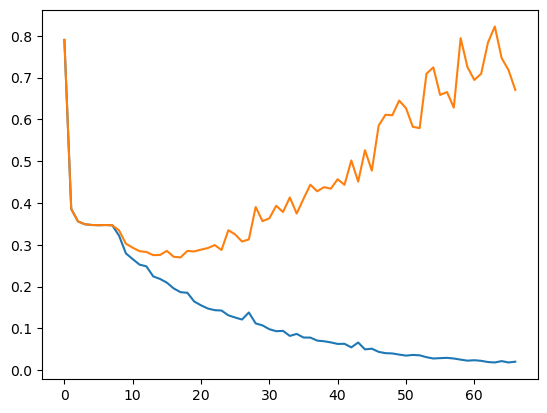

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_)
plt.plot(test_)